# Lab: Protein Dynamics Analysis 🧬

> "Proteins are not static structures—they are dynamic machines that dance through time!"

This lab explores protein dynamics through computational simulation. We'll learn how proteins move, which regions are flexible, and how motion relates to biological function.

**By the end of this lab, you'll be able to:**
- Download and prepare protein structures from the PDB
- Analyze static protein properties (Ramachandran plots, B-factors)
- Run molecular dynamics simulations
- Visualize and interpret protein motion
- Connect protein dynamics to biological function

**Real-world relevance**: Understanding protein dynamics is crucial for drug design, enzyme engineering, and understanding diseases like Alzheimer's (caused by protein misfolding)!


## 1. Download and Prepare the Structure

We automatically download a protein structure from the RCSB database in mmCIF format and convert it to PDB.

**What you'll learn:**
- What the Protein Data Bank (PDB) is - the world's largest repository of protein structures
- How protein structures are stored (mmCIF vs PDB formats)
- Why formats matter in computational biology

**💡 Think about it**: The PDB contains over 200,000 structures! Each one represents years of experimental work. What protein are we analyzing today?

**Outcome:** You now have a real protein structure ready to analyze.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import MMCIFParser, PDBIO, PDBParser
import mdtraj as md
import requests
from openmm.app import PDBFile, Modeller, ForceField, Simulation, DCDReporter
from openmm import LangevinIntegrator
from openmm.app import NoCutoff, CutoffNonPeriodic
from openmm.unit import kelvin, picosecond, nanometer


In [2]:
def download_structure(pdb_id, out_dir="structures"):
    """Download mmCIF using RCSB API and return local filepath."""
    pdb_id = pdb_id.lower()
    os.makedirs(out_dir, exist_ok=True)
    url = f"https://files.rcsb.org/download/{pdb_id}.cif"
    out_file = os.path.join(out_dir, f"{pdb_id}.cif")
    
    r = requests.get(url)
    if r.status_code != 200:
        raise ValueError(f"Failed to download mmCIF for {pdb_id}")
    
    with open(out_file, "wb") as f:
        f.write(r.content)
    
    print(f"[✅] Downloaded {pdb_id}.cif to {out_file}")
    return out_file


def cif_to_pdb(cif_file, out_file=None):
    """Convert mmCIF file to PDB using BioPython."""
    if out_file is None:
        out_file = cif_file.replace(".cif", ".pdb")
    
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure("protein", cif_file)
    io = PDBIO()
    io.set_structure(structure)
    io.save(out_file)
    
    print(f"[✅] Converted to PDB → {out_file}")
    return out_file


In [3]:
# Download a small protein structure 
# Try different PDB IDs! Some suggestions:
# - 1E0L: Small protein (good for quick MD)
# - 1UBQ: Ubiquitin (well-studied, very flexible)
# - 1L2Y: Small protein (fast simulation)
# - 1CRN: Crambin (small, stable protein)

pdb_id = "1E0L"
print(f"📥 Downloading structure {pdb_id} from RCSB PDB...")
cif_file = download_structure(pdb_id)
pdb_file = cif_to_pdb(cif_file)


📥 Downloading structure 1E0L from RCSB PDB...
[✅] Downloaded 1e0l.cif to structures/1e0l.cif
[✅] Converted to PDB → structures/1e0l.pdb


### 🔍 Visualize the Structure (Optional)

Let's take a look at our protein in 3D! This helps us understand what we're working with.


In [24]:
# Try to visualize the structure using py3Dmol (if available)
# Install with: pip install py3Dmol

try:
    import py3Dmol
    
    # Read PDB file
    with open('structures/1e0l.pdb', 'r') as f:
        pdb_content = f.read()
    
    # Create 3D viewer
    view = py3Dmol.view(width=600, height=400)
    view.addModel(pdb_content, 'pdb')
    view.setStyle({'cartoon': {'color': 'spectrum'}})
    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()
    print("✅ 3D structure visualization displayed above!")
    
except ImportError:
    print("💡 Tip: Install py3Dmol to visualize structures: pip install py3Dmol")
    print("   For now, you can view the structure at: https://www.rcsb.org/structure/{}".format(pdb_id))
except Exception as e:
    print(f"Could not display 3D structure: {e}")
    print("💡 You can view the structure at: https://www.rcsb.org/structure/{}".format(pdb_id))


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

✅ 3D structure visualization displayed above!


## 2. Static Protein Analysis

Before simulating motion, we examine the protein in its static state. Think of this as a "snapshot" from a crystallography experiment.

**We will:**
- Compute phi/psi backbone torsion angles
- Plot a Ramachandran diagram → shows which conformations are allowed
- Extract B-factors → reflect how much atoms fluctuate in experiments

**This teaches:**
- Where protein chains can bend (like a flexible hose vs a rigid pipe)
- Which regions are flexible vs rigid (loops vs alpha-helices)
- How crystallography captures but also simplifies motion (a single snapshot of a dancing protein!)

**🎯 Key Question**: Can we predict which parts will move the most, just from the static structure?

**Outcome:** A clearer understanding that even static crystallography hints at dynamics.


### 2.1 Phi/Psi Angles and Ramachandran Plot

The **Ramachandran plot** visualizes backbone torsion angles (phi and psi) and shows which conformations are sterically allowed. 

**Think of it like this**: Imagine a protein backbone as a chain of beads. Phi and psi are like the angles of rotation at each joint. Some combinations are impossible (like trying to fold your arm the wrong way), while others create familiar structures:
- **Alpha-helices** cluster in one region (top-left)
- **Beta-sheets** cluster in another region (top-right)  
- **Loops** can be anywhere but prefer certain angles

This is fundamental to understanding protein secondary structure!


In [5]:
def compute_ramachandran(pdb_file):
    """Compute phi and psi backbone torsion angles."""
    traj = md.load(pdb_file)
    phi = md.compute_phi(traj)[1].flatten()
    psi = md.compute_psi(traj)[1].flatten()
    return phi, psi


def plot_ramachandran(phi, psi, title="Ramachandran Plot"):
    """Plot phi vs psi angles showing allowed conformations."""
    plt.figure(figsize=(8, 8))
    plt.scatter(np.degrees(phi), np.degrees(psi), s=25, alpha=0.7, c='blue')
    plt.xlabel("Phi (°)", fontsize=12)
    plt.ylabel("Psi (°)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.3)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


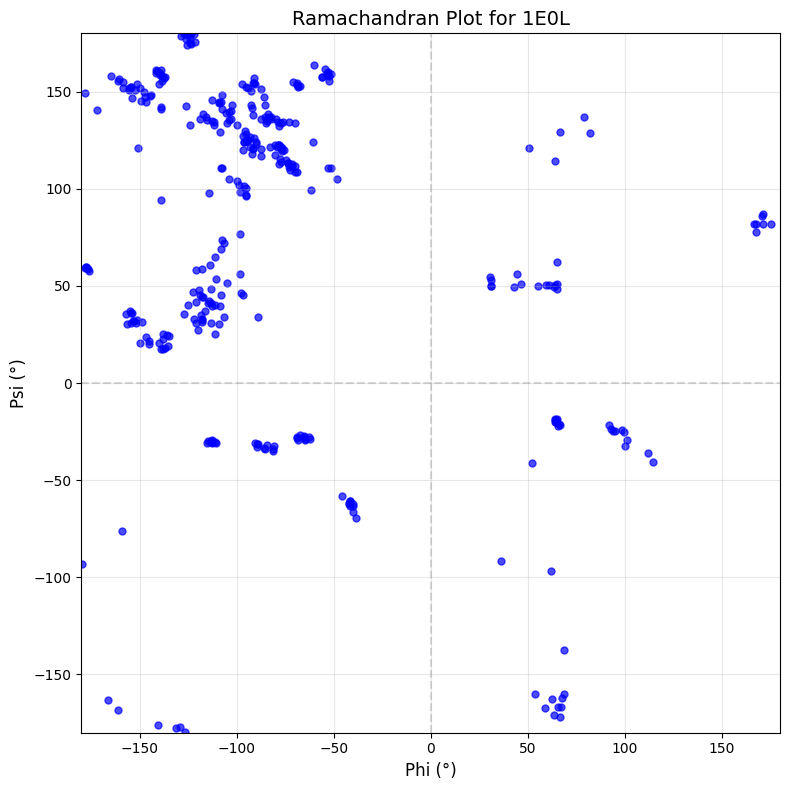

Computed 360 phi/psi angle pairs


In [6]:
phi, psi = compute_ramachandran(pdb_file)
plot_ramachandran(phi, psi, title=f"Ramachandran Plot for {pdb_id}")
print(f"Computed {len(phi)} phi/psi angle pairs")


### 2.2 B-Factors (Temperature Factors)

**B-factors** (also called temperature factors) from crystallography reflect atomic displacement. Higher B-factors indicate more flexible regions of the protein.

**💡 Analogy**: Think of B-factors like a "blurriness" measure in a photo. If you took many photos of a person dancing, the moving parts would be blurry (high B-factor), while still parts would be sharp (low B-factor).

**🤔 Prediction**: Before we run the MD simulation, can you guess which regions will have high B-factors? (Hint: Loops and chain termini are usually more flexible than secondary structure elements!)


In [7]:
def extract_bfactor(pdb_file):
    """Extract B-factors from PDB file."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    
    b_factors = []
    for atom in structure.get_atoms():
        b_factors.append(atom.get_bfactor())
    
    return np.array(b_factors)

def plot_bfactor(bfactors):
    """Plot B-factor distribution along the protein."""
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Create a color gradient based on B-factor values
    colors = plt.cm.Reds((bfactors - bfactors.min()) / (bfactors.max() - bfactors.min() + 1e-10))
    
    # Plot line with color gradient (simplified as single color for clarity)
    ax.plot(bfactors, lw=2, color='darkred', alpha=0.7)
    
    # Highlight high B-factor regions
    threshold = np.percentile(bfactors, 75)
    high_bf = bfactors > threshold
    ax.fill_between(range(len(bfactors)), 0, bfactors, 
                     where=high_bf, alpha=0.3, color='red', 
                     label=f'High flexibility (top 25%)')
    
    ax.set_xlabel("Atom Index", fontsize=12)
    ax.set_ylabel("B-Factor (Å²)", fontsize=12)
    ax.set_title("B-Factor Distribution (Higher = More Flexible)", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Statistics:")
    print(f"   Mean B-factor: {np.mean(bfactors):.2f} Å²")
    print(f"   Max B-factor: {np.max(bfactors):.2f} Å² (atom {np.argmax(bfactors)})")
    print(f"   Min B-factor: {np.min(bfactors):.2f} Å² (atom {np.argmin(bfactors)})")
    print(f"   High flexibility regions (>75th percentile): {(high_bf.sum() / len(bfactors) * 100):.1f}% of atoms")


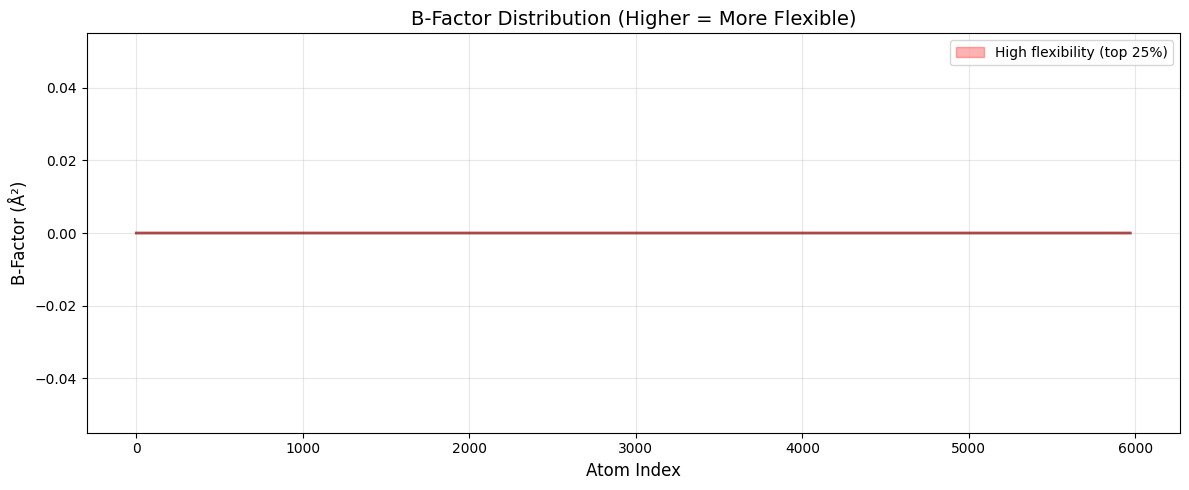

📊 Statistics:
   Mean B-factor: 0.00 Å²
   Max B-factor: 0.00 Å² (atom 0)
   Min B-factor: 0.00 Å² (atom 0)
   High flexibility regions (>75th percentile): 0.0% of atoms


In [8]:
bfactors = extract_bfactor(pdb_file)
plot_bfactor(bfactors)


## 3. Running a Molecular Dynamics Simulation 🎬

Now we let the protein move in a simulated environment! This is like creating a movie of protein motion.

**We will:**
- Add an implicit solvent (water effects, but simplified - like a "friction" effect)
- Minimize energy (relax the structure - like letting a stretched spring settle)
- Run a short MD simulation using OpenMM (like a physics simulation in a video game!)

**This gives us:**
- A trajectory over time → like a movie of protein motion with thousands of frames

**⏱️ Time Note**: This simulation represents 0.2 nanoseconds of "real" time. In reality, proteins move on timescales from picoseconds to seconds. We're capturing the fast movements!

**🎮 Think of it like**: Simulating how a protein would move if you could watch it frame-by-frame at atomic resolution.

**Outcome:** A .dcd file containing ~1000+ snapshots of the protein shape changing.


In [9]:
def run_md_simulation(pdb_file, temperature=300, sim_time_ns=0.2, out_dcd="traj.dcd", show_progress=True):
    """
    Run an implicit-solvent MD simulation of a small protein.
    
    Parameters:
    - pdb_file: Input PDB structure
    - temperature: Simulation temperature in Kelvin (default: 300K ≈ room temp)
    - sim_time_ns: Simulation time in nanoseconds (default: 0.2 ns)
    - out_dcd: Output trajectory file name
    - show_progress: Whether to show progress updates
    """
    import time
    start_time = time.time()
    
    print(f"🎬 Starting MD simulation...")
    print(f"   📊 Temperature: {temperature} K ({temperature-273.15:.1f}°C)")
    print(f"   ⏱️  Simulation time: {sim_time_ns} ns")
    print(f"   📁 Output file: {out_dcd}")
    print()
    
    # Load structure
    pdb = PDBFile(pdb_file)
    modeller = Modeller(pdb.topology, pdb.positions)
    
    print(f"   📦 Loaded structure: {len(list(modeller.topology.atoms()))} atoms")
    
    # Create force field (AMBER with implicit solvent)
    # Note: For implicit solvent, we use a simpler force field
    try:
        ff = ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
        print("   ✅ Using AMBER14 force field with implicit solvent")
    except:
        # Fallback if implicit solvent files not available
        ff = ForceField("amber14-all.xml")
        print("   ⚠️  Using AMBER14 force field (no implicit solvent)")
    
    # Use NoCutoff for implicit solvent (no periodic boundary conditions needed)
    # Import here to ensure it's available
    import openmm.app as app
    system = ff.createSystem(modeller.topology, 
                            nonbondedMethod=app.NoCutoff, 
                            constraints=None)
    
    # Create integrator (Langevin dynamics for temperature control)
    integrator = LangevinIntegrator(temperature*kelvin, 
                                   1/picosecond,  # friction coefficient
                                   0.002*picosecond)  # time step
    
    # Create simulation
    sim = Simulation(modeller.topology, system, integrator)
    sim.context.setPositions(modeller.positions)
    
    # Energy minimization (relax initial structure)
    print("   🔧 Minimizing energy (relaxing structure)...")
    sim.minimizeEnergy()
    print("   ✅ Minimization complete")
    
    # Set up trajectory reporter (save every 100 steps)
    sim.reporters.append(DCDReporter(out_dcd, 100))
    
    # Run simulation
    steps = int((sim_time_ns * 1000 * 1000) / 2)  # 0.002 ps time step
    frames = steps // 100
    print(f"   🏃 Running {steps:,} steps ({frames:,} frames will be saved)...")
    print("   💡 This may take a few minutes...")
    
    sim.step(steps)
    
    elapsed = time.time() - start_time
    print(f"   ✅ MD complete! Saved {out_dcd}")
    print(f"   ⏱️  Total time: {elapsed:.1f} seconds")
    print(f"   📈 Generated {frames:,} frames of trajectory")
    
    return out_dcd


In [10]:
# Run a short MD simulation (0.2 ns)
# Note: This may take a few minutes depending on your system
traj_file = run_md_simulation(pdb_file, sim_time_ns=0.2, out_dcd="traj.dcd")


🎬 Starting MD simulation...
   📊 Temperature: 300 K (26.9°C)
   ⏱️  Simulation time: 0.2 ns
   📁 Output file: traj.dcd

   📦 Loaded structure: 597 atoms
   ✅ Using AMBER14 force field with implicit solvent
   🔧 Minimizing energy (relaxing structure)...
   ✅ Minimization complete
   🏃 Running 100,000 steps (1,000 frames will be saved)...
   💡 This may take a few minutes...
   ✅ MD complete! Saved traj.dcd
   ⏱️  Total time: 47.3 seconds
   📈 Generated 1,000 frames of trajectory


### 🎬 Visualize the Trajectory

Before analyzing the motion quantitatively, let's visualize the trajectory to see how the protein moves! This helps us get an intuitive understanding of the dynamics before diving into the numbers.


In [11]:
def visualize_trajectory_animated(pdb_file, traj_file, step=10, delay=200):
    """
    Create an animated movie of the trajectory using py3Dmol.
    
    Parameters:
    - pdb_file: Path to PDB file (reference structure)
    - traj_file: Path to trajectory file
    - step: Show every Nth frame (default: 10, smaller = smoother but slower)
    - delay: Delay between frames in milliseconds (default: 200)
    """
    try:
        import py3Dmol
        
        # Load trajectory
        traj = md.load(traj_file, top=pdb_file)
        
        print(f"🎬 Creating animated trajectory movie...")
        print(f"📹 Trajectory: {traj.n_frames} frames")
        print(f"📊 Displaying every {step} frame(s)")
        print(f"⏱️  Animation speed: {delay}ms per frame")
        
        # Select frames to display (every Nth frame)
        frame_indices = range(0, traj.n_frames, step)
        n_frames_to_show = len(list(frame_indices))
        
        # Create viewer
        view = py3Dmol.view(width=800, height=600)
        
        # Add all frames as models
        for i, frame_idx in enumerate(frame_indices):
            # Save frame as temporary PDB
            frame_traj = traj[frame_idx]
            temp_pdb = f"temp_frame_{frame_idx}.pdb"
            frame_traj.save_pdb(temp_pdb)
            
            # Read PDB content
            with open(temp_pdb, 'r') as f:
                pdb_content = f.read()
            
            # Add to viewer
            view.addModel(pdb_content, 'pdb')
            
            # Style: use consistent color scheme for animation
            view.setStyle({'model': i}, {'cartoon': {'color': 'spectrum'}})
            
            # Clean up temp file
            os.remove(temp_pdb)
        
        # Set background
        view.setBackgroundColor('white')
        
        # Animate: cycle through all models
        view.animate({'loop': 'forward', 'interval': delay})
        
        # Zoom to fit
        view.zoomTo()
        
        # Show the viewer
        view.show()
        
        print(f"✅ Animated trajectory movie displayed above!")
        print(f"🎥 Movie shows {n_frames_to_show} frames from the simulation")
        print(f"💡 The animation loops automatically - watch the protein move!")
        print(f"💡 Tip: Adjust 'step' parameter to make animation smoother (smaller) or faster (larger)")
        
    except ImportError:
        print("💡 Tip: Install py3Dmol to visualize animated trajectories: pip install py3Dmol")
    except Exception as e:
        print(f"Could not display animated trajectory: {e}")
        print("💡 Alternative: Use visualize_trajectory() to see multiple frames at once")


In [12]:
def visualize_trajectory(pdb_file, traj_file, n_frames=10):
    """
    Visualize trajectory frames using py3Dmol (if available).
    
    Parameters:
    - pdb_file: Path to PDB file (reference structure)
    - traj_file: Path to trajectory file
    - n_frames: Number of frames to display (default: 10)
    """
    try:
        import py3Dmol
        
        # Load trajectory
        traj = md.load(traj_file, top=pdb_file)
        
        print(f"📹 Trajectory loaded: {traj.n_frames} frames")
        print(f"📊 Displaying {n_frames} frames from the trajectory")
        
        # Select frames to display (evenly spaced)
        frame_indices = np.linspace(0, traj.n_frames - 1, n_frames, dtype=int)
        
        # Create viewer
        view = py3Dmol.view(width=800, height=600)
        
        # Add frames as models
        for i, frame_idx in enumerate(frame_indices):
            # Save frame as temporary PDB
            frame_traj = traj[frame_idx]
            temp_pdb = f"temp_frame_{frame_idx}.pdb"
            frame_traj.save_pdb(temp_pdb)
            
            # Read PDB content
            with open(temp_pdb, 'r') as f:
                pdb_content = f.read()
            
            # Add to viewer
            view.addModel(pdb_content, 'pdb')
            
            # Style: use different colors for different frames
            color = f"0x{int(255 * i / (n_frames-1)):02x}00ff" if n_frames > 1 else "0x00ff00"
            view.setStyle({'model': i}, {'cartoon': {'color': color}})
            
            # Clean up temp file
            os.remove(temp_pdb)
        
        # Set background and show
        view.setBackgroundColor('white')
        view.zoomTo()
        view.show()
        
        print(f"✅ Trajectory visualization displayed above!")
        print(f"💡 Tip: The colors change from blue to red showing progression through the trajectory")
        
    except ImportError:
        print("💡 Tip: Install py3Dmol to visualize trajectories: pip install py3Dmol")
        print("   For now, you can view individual frames using: md.load(traj_file, top=pdb_file)[frame_idx]")
    except Exception as e:
        print(f"Could not display trajectory: {e}")
        print("💡 Alternative: You can load and analyze individual frames using mdtraj")
        
def visualize_trajectory_frames(pdb_file, traj_file, frame_indices=[0, 10, 50, 100]):
    """
    Save selected frames from trajectory for visualization.
    
    Parameters:
    - pdb_file: Path to PDB file (reference structure)
    - traj_file: Path to trajectory file
    - frame_indices: List of frame indices to save (default: [0, 10, 50, 100])
    """
    try:
        import py3Dmol
        
        # Load trajectory
        traj = md.load(traj_file, top=pdb_file)
        
        print(f"📹 Trajectory: {traj.n_frames} frames")
        print(f"📊 Displaying frames: {frame_indices}")
        
        # Create viewer
        view = py3Dmol.view(width=800, height=600)
        
        colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
        
        for i, frame_idx in enumerate(frame_indices):
            if frame_idx >= traj.n_frames:
                continue
                
            # Save frame as temporary PDB
            frame_traj = traj[frame_idx]
            temp_pdb = f"temp_frame_{frame_idx}.pdb"
            frame_traj.save_pdb(temp_pdb)
            
            # Read PDB content
            with open(temp_pdb, 'r') as f:
                pdb_content = f.read()
            
            # Add to viewer
            view.addModel(pdb_content, 'pdb')
            
            # Style: different colors for different frames
            color = colors[i % len(colors)]
            view.setStyle({'model': i}, {'cartoon': {'color': color}})
            
            # Clean up temp file
            os.remove(temp_pdb)
        
        # Set background and show
        view.setBackgroundColor('white')
        view.zoomTo()
        view.show()
        
        print(f"✅ Selected frames displayed above!")
        print(f"💡 Colors represent different time points in the simulation")
        
    except ImportError:
        print("💡 Tip: Install py3Dmol to visualize trajectories: pip install py3Dmol")
    except Exception as e:
        print(f"Could not display trajectory: {e}")


In [25]:
# Option 1: Visualize multiple frames at once (overlay)
# Shows frames with color gradient (blue → red) showing progression
visualize_trajectory(pdb_file, traj_file, n_frames=10)

# Option 2: Animated movie (cycles through frames automatically)
# Uncomment the line below to see an animated movie of the trajectory
# visualize_trajectory_animated(pdb_file, traj_file, step=10, delay=200)

# Option 3: Visualize specific frames
# visualize_trajectory_frames(pdb_file, traj_file, frame_indices=[0, 50, 100, 200, 500])


📹 Trajectory loaded: 1000 frames
📊 Displaying 10 frames from the trajectory


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

✅ Trajectory visualization displayed above!
💡 Tip: The colors change from blue to red showing progression through the trajectory


In [14]:
# trajectory visualization

## 4. Analyzing Protein Motion 🎭

Now for the exciting part! We have a "movie" of protein motion. Let's analyze it to understand how the protein moves.

**We will compute:**
- **RMSD** (Root Mean Square Deviation) - how much the structure deviates over time
- **RMSF** (Root Mean Square Fluctuation) - which residues are flexible
- **Free Energy Landscape** - what stable conformations exist

**This teaches:**
- Proteins visit many shapes, not just one (like a dancer performing many poses)
- Stability is linked to energy minima (proteins "prefer" certain conformations)
- Function often involves movement between states (enzymes need to open/close, receptors need to bind/unbind)

**🤔 Key Questions**:
- Do the flexible regions match what we predicted from B-factors?
- How much does the protein deviate from its starting structure?
- Are there multiple stable conformations?

**Outcome:** You see how biological function emerges from dynamics, not static structure.


### 4.1 Loading the Trajectory and Computing RMSD/RMSF


In [15]:
def analyze_trajectory(pdb_file, traj_file):
    """
    Analyze MD trajectory to compute RMSD and RMSF.
    
    RMSD (Root Mean Square Deviation): Measures overall structural change
    RMSF (Root Mean Square Fluctuation): Measures per-residue flexibility
    """
    # Load trajectory using mdtraj
    traj = md.load(traj_file, top=pdb_file)
    
    print(f"Trajectory loaded: {traj.n_frames} frames, {traj.n_atoms} atoms")
    
    # RMSD to first frame (reference)
    rmsd = md.rmsd(traj, traj, 0)
    
    # RMSF per atom (relative to frame 0)
    # md.rmsf requires trajectory and reference (first frame)
    rmsf_atoms = md.rmsf(traj, traj[0])
    
    # Compute per-residue RMSF using CA atoms only
    # Select CA atoms for per-residue analysis
    ca_atoms = traj.topology.select('name == CA')
    rmsf = rmsf_atoms[ca_atoms]
    
    return traj, rmsd, rmsf


In [16]:
traj, rmsd, rmsf = analyze_trajectory(pdb_file, traj_file)


Trajectory loaded: 1000 frames, 597 atoms


### 4.2 RMSD Over Time

**RMSD** shows how much the protein structure deviates from its starting conformation. A stable protein will show relatively low RMSD, while flexible proteins will show higher RMSD.


In [17]:
def plot_rmsd(rmsd):
    """Plot RMSD over time."""
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Convert nm to Å
    rmsd_angstrom = rmsd * 10
    
    # Plot with color gradient (blue = early, red = late)
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(rmsd_angstrom)))
    ax.plot(rmsd_angstrom, lw=2, color='darkblue', alpha=0.7, label='RMSD')
    
    # Add mean line
    mean_rmsd = np.mean(rmsd_angstrom)
    ax.axhline(mean_rmsd, color='red', linestyle='--', alpha=0.7, 
               label=f'Mean: {mean_rmsd:.2f} Å')
    
    # Fill area to show variation
    ax.fill_between(range(len(rmsd_angstrom)), 0, rmsd_angstrom, 
                     alpha=0.2, color='blue')
    
    ax.set_xlabel("Frame", fontsize=12)
    ax.set_ylabel("RMSD (Å)", fontsize=12)
    ax.set_title("RMSD Over Time (Relative to First Frame)", fontsize=14)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"📊 RMSD Statistics:")
    print(f"   Mean RMSD: {mean_rmsd:.2f} Å")
    print(f"   Max RMSD: {np.max(rmsd_angstrom):.2f} Å (frame {np.argmax(rmsd_angstrom)})")
    print(f"   Min RMSD: {np.min(rmsd_angstrom):.2f} Å")
    print(f"   Standard deviation: {np.std(rmsd_angstrom):.2f} Å")
    
    # Interpretation
    if mean_rmsd < 1.0:
        print("   💡 Interpretation: Very stable structure (low RMSD)")
    elif mean_rmsd < 2.5:
        print("   💡 Interpretation: Moderately stable (some flexibility)")
    else:
        print("   💡 Interpretation: Highly flexible structure")


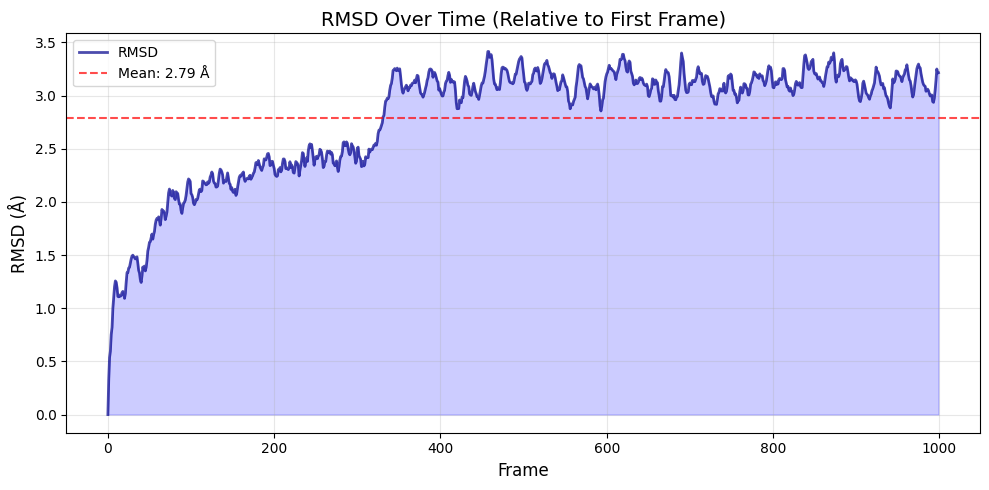

📊 RMSD Statistics:
   Mean RMSD: 2.79 Å
   Max RMSD: 3.41 Å (frame 457)
   Min RMSD: 0.00 Å
   Standard deviation: 0.55 Å
   💡 Interpretation: Highly flexible structure


In [18]:
plot_rmsd(rmsd)


### 4.3 RMSF Per Residue

**RMSF** identifies which residues are most flexible. This is crucial for understanding functional regions, binding sites, and areas that might be important for conformational changes.


In [19]:
def plot_rmsf(rmsf):
    """Plot RMSF per residue."""
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Convert nm to Å
    rmsf_angstrom = rmsf * 10
    
    # Create color gradient based on RMSF values
    colors = plt.cm.Greens((rmsf_angstrom - rmsf_angstrom.min()) / 
                          (rmsf_angstrom.max() - rmsf_angstrom.min() + 1e-10))
    
    # Plot with color-coded bars
    x = np.arange(len(rmsf_angstrom))
    bars = ax.bar(x, rmsf_angstrom, color=colors, alpha=0.7, edgecolor='darkgreen', linewidth=0.5)
    
    # Add mean line
    mean_rmsf = np.mean(rmsf_angstrom)
    ax.axhline(mean_rmsf, color='red', linestyle='--', alpha=0.7, 
               label=f'Mean: {mean_rmsf:.2f} Å')
    
    # Highlight top flexible residues
    threshold = np.percentile(rmsf_angstrom, 75)
    high_rmsf = rmsf_angstrom > threshold
    ax.bar(x[high_rmsf], rmsf_angstrom[high_rmsf], 
           color='red', alpha=0.5, label=f'Top 25% flexible')
    
    ax.set_xlabel("Residue Index", fontsize=12)
    ax.set_ylabel("RMSF (Å)", fontsize=12)
    ax.set_title("Residue Flexibility (RMSF) - Which Residues Move the Most?", fontsize=14)
    ax.grid(alpha=0.3, axis='y')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Find most flexible residues
    max_idx = np.argmax(rmsf_angstrom)
    top_5_indices = np.argsort(rmsf_angstrom)[-5:][::-1]
    
    print(f"📊 RMSF Statistics:")
    print(f"   Most flexible residue: {max_idx} (RMSF: {rmsf_angstrom[max_idx]:.2f} Å)")
    print(f"   Mean RMSF: {mean_rmsf:.2f} Å")
    print(f"   Top 5 most flexible residues:")
    for i, idx in enumerate(top_5_indices, 1):
        print(f"      {i}. Residue {idx}: {rmsf_angstrom[idx]:.2f} Å")
    
    print(f"\n💡 Tip: High RMSF regions are often:")
    print(f"   - Loop regions (between secondary structures)")
    print(f"   - Chain termini (N- and C-termini)")
    print(f"   - Functional sites (binding sites, active sites)")


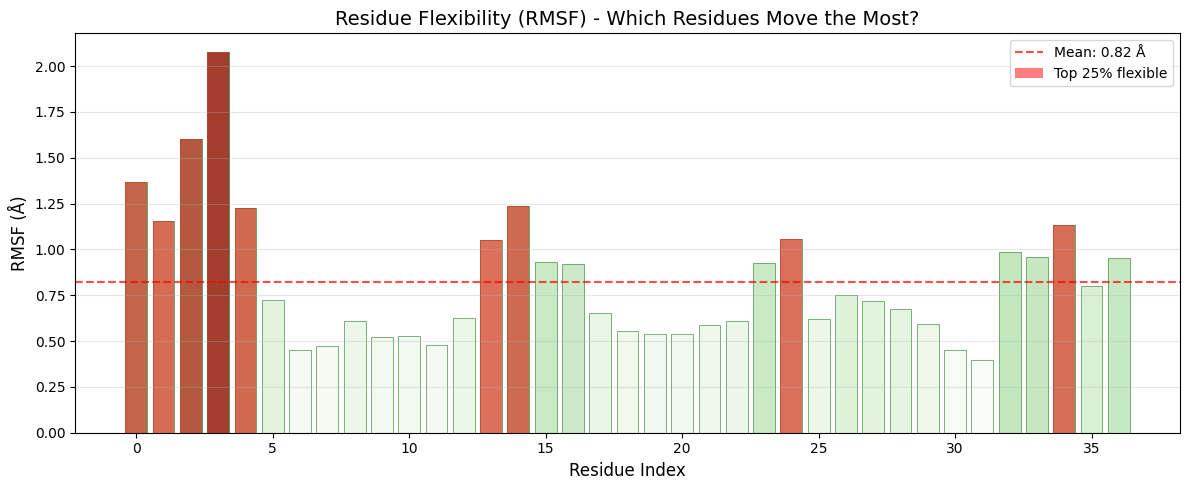

📊 RMSF Statistics:
   Most flexible residue: 3 (RMSF: 2.08 Å)
   Mean RMSF: 0.82 Å
   Top 5 most flexible residues:
      1. Residue 3: 2.08 Å
      2. Residue 2: 1.60 Å
      3. Residue 0: 1.37 Å
      4. Residue 14: 1.24 Å
      5. Residue 4: 1.23 Å

💡 Tip: High RMSF regions are often:
   - Loop regions (between secondary structures)
   - Chain termini (N- and C-termini)
   - Functional sites (binding sites, active sites)


In [20]:
plot_rmsf(rmsf)


### 4.4 Free Energy Landscape

The **Free Energy Landscape** shows the probability distribution of protein conformations. 

**Think of it like a topographic map:**
- **Deep valleys** (dark blue/purple) = stable conformations (low energy, protein "prefers" these)
- **High peaks** (yellow) = unstable conformations (high energy, rarely visited)
- **Multiple valleys** = protein can adopt multiple stable conformations

This is computed using Principal Component Analysis (PCA) to reduce dimensionality from thousands of atomic coordinates to just 2 dimensions that capture the most important motions.

**💡 Key Insight**: Proteins don't just have ONE structure - they visit many conformations, but spend most time in the low-energy states (valleys)!


## 🎯 Challenge Questions

Test your understanding with these questions:

1. **Prediction vs Reality**: Did the regions with high B-factors (from crystallography) match the regions with high RMSF (from MD)? Why or why not?

2. **RMSD Interpretation**: If RMSD increases over time, what does that mean? Is the protein becoming more or less stable?

3. **Free Energy Landscape**: If you see multiple valleys in the free energy landscape, what does that tell you about the protein?

4. **Biological Function**: How might flexibility be important for a protein's function? Can you think of examples where rigidity would be important instead?

5. **Simulation Limitations**: We simulated 0.2 nanoseconds. Real biological processes can take microseconds to seconds. What events might we miss?

**💡 Bonus Challenge**: Try running the simulation with a different temperature (e.g., 350K = 77°C). How does the RMSD and flexibility change? What does this tell you about temperature effects on proteins?


In [21]:
def compute_fel(traj, n_components=2):
    """
    Compute Free Energy Landscape using Principal Component Analysis.
    
    Projects the high-dimensional trajectory onto 2D using PCA.
    """
    # Reshape coordinates: (n_frames, n_atoms, 3) -> (n_frames, n_atoms*3)
    X = traj.xyz.reshape(traj.n_frames, -1)
    
    # Center the data
    X -= X.mean(axis=0)
    
    # Compute PCA using SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Project onto first two principal components
    pc1 = U[:, 0] * S[0]
    pc2 = U[:, 1] * S[1]
    
    print(f"PC1 explains {S[0]**2 / np.sum(S**2) * 100:.1f}% of variance")
    print(f"PC2 explains {S[1]**2 / np.sum(S**2) * 100:.1f}% of variance")
    
    return pc1, pc2

def plot_fel(pc1, pc2, bins=50):
    """
    Plot Free Energy Landscape.
    
    Free energy is computed as: G = -kT * ln(P)
    where P is the probability density.
    
    Think of this as a topographic map where:
    - Valleys (dark blue/purple) = stable conformations (low energy)
    - Peaks (yellow) = unstable conformations (high energy)
    """
    # Compute 2D histogram
    hist, xedges, yedges = np.histogram2d(pc1, pc2, bins=bins)
    
    # Normalize to probability
    hist = hist / np.sum(hist)
    
    # Compute free energy (in arbitrary units)
    # Add small epsilon to avoid log(0)
    free_energy = -np.log(hist + 1e-10)
    
    # Plot
    fig, ax = plt.subplots(figsize=(9, 8))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(free_energy.T, origin='lower', cmap='viridis', 
                   extent=extent, aspect='auto', interpolation='bilinear')
    
    # Add contour lines for better visualization
    contour_levels = np.linspace(free_energy.min(), free_energy.max(), 10)
    contours = ax.contour(free_energy.T, levels=contour_levels, 
                         extent=extent, colors='white', alpha=0.3, linewidths=0.5)
    
    cbar = plt.colorbar(im, ax=ax, label='Free Energy (a.u.)')
    ax.set_xlabel("Principal Component 1", fontsize=12)
    ax.set_ylabel("Principal Component 2", fontsize=12)
    ax.set_title("Free Energy Landscape\n(Valleys = Stable, Peaks = Unstable)", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Find energy minima (stable states)
    min_energy = np.min(free_energy)
    max_energy = np.max(free_energy)
    min_pos = np.unravel_index(np.argmin(free_energy), free_energy.shape)
    
    print(f"📊 Free Energy Statistics:")
    print(f"   Energy range: {min_energy:.2f} to {max_energy:.2f} (a.u.)")
    print(f"   Lowest energy state: PC1={xedges[min_pos[0]]:.2f}, PC2={yedges[min_pos[1]]:.2f}")
    print(f"\n💡 Interpretation:")
    print(f"   - Deep valleys (dark regions) = stable conformations the protein prefers")
    print(f"   - High peaks (bright regions) = rarely visited, unstable states")
    print(f"   - Multiple valleys = protein can adopt multiple stable conformations")
    print(f"   - This is like a 'conformational map' showing where the protein 'lives'")


PC1 explains 83.2% of variance
PC2 explains 7.6% of variance


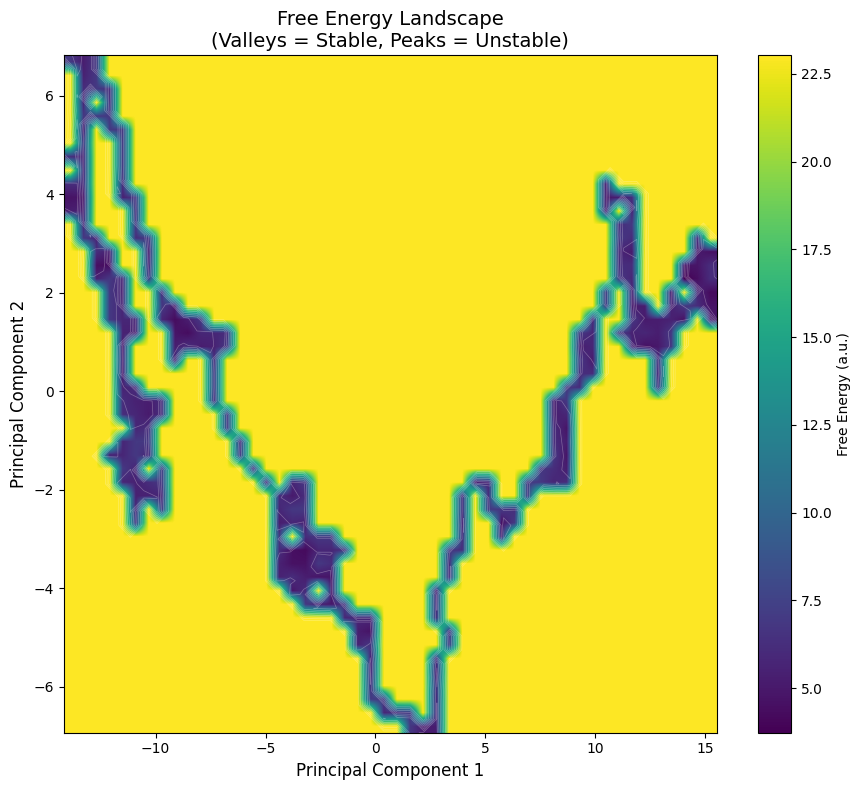

📊 Free Energy Statistics:
   Energy range: 3.73 to 23.03 (a.u.)
   Lowest energy state: PC1=13.74, PC2=2.14

💡 Interpretation:
   - Deep valleys (dark regions) = stable conformations the protein prefers
   - High peaks (bright regions) = rarely visited, unstable states
   - Multiple valleys = protein can adopt multiple stable conformations
   - This is like a 'conformational map' showing where the protein 'lives'


In [22]:
pc1, pc2 = compute_fel(traj)
plot_fel(pc1, pc2)


## Summary & Key Takeaways 🎓

In this lab, you've learned:

1. **Structure Download**: How to retrieve protein structures from the PDB (the world's largest protein structure database)
2. **Static Analysis**: Ramachandran plots and B-factors reveal protein geometry and flexibility hints from crystallography
3. **MD Simulation**: How to simulate protein motion using OpenMM (creating a "movie" of protein dynamics)
4. **Dynamic Analysis**: RMSD, RMSF, and free energy landscapes reveal how proteins move and which conformations are stable

**🔑 Key Insight**: Proteins are not static structures - they are dynamic machines whose function emerges from motion. Understanding dynamics is crucial for:
- **Drug Design**: Drugs often target specific conformations
- **Enzyme Catalysis**: Enzymes need to move to bind substrates and release products
- **Protein Engineering**: Designing proteins that can move in desired ways
- **Disease Understanding**: Many diseases (like Alzheimer's) involve protein misfolding and dynamics

**🚀 Next Steps**:
- Try different proteins! Change the `pdb_id` variable and see how different proteins behave
- Experiment with simulation parameters (temperature, time)
- Compare B-factors (static) with RMSF (dynamic) - do they match?
- Explore the free energy landscape - how many stable states does your protein have?

**📚 Real-World Applications**:
- **Allostery**: Proteins change shape when they bind ligands (like a lock and key that morphs)
- **Protein Folding**: Understanding how proteins fold (and misfold) is crucial for disease
- **Drug Binding**: Drugs often work by stabilizing specific conformations
- **Evolution**: Protein dynamics can evolve to optimize function
